<center> <h2>Mohamed DHAOUI , MS BIG DATA 2018-2019 <h1><center>
    <center> <h2>Rendu du Challenge Machine Leaning <h2><center>


Le challenge consiste à développer un modèle permettant de mesurer la similarité entre les images . 
Nous avons comme entrée une table des pairs des images , quelques scores de similarité et une variable binaire qui vaut 1 si les images sont similaire et 0 sinon . 
Cela nous invite à penser à des branches de d'étude statistique qui s'appellent la Metric Learning et le pairwise similarity . 
Dans ce notebook , je passerai en revue les différentes approches qui j'ai envisagé pour la modélisation , les contraintes techniques rencontrées ainsi que les résultats obtenus .



* 1- Analyse exploratoire des données
* 2- Features Engineering
* 3- Modélisation et comparaison des résultats
* 4-Conclusion


# 1- Analyse exploratoire des données 


Avant de charger les données , commençons par importer tous les packages nécessaires

In [0]:
%matplotlib inline
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from  sklearn.model_selection  import ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import matplotlib.pylab as plt 
import numpy as np
import seaborn
import warnings
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV


In [0]:
import tensorflow as tf

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
import gc
import psutil
#!{sys.executable} -m pip install xgboost
seaborn.set_context('notebook')#sthash.1UeHTyaj.dpuf
plt.rcParams['figure.figsize'] = (15, 5) 
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 40)
pd.options.display.max_colwidth = 50
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
warnings.filterwarnings('ignore')

gc.enable()
#import sys


## 1.1 Chargement des données


Pour le challenge , il y a trois fichiers à exploiter : 
* xtrain_challenge : les données d'entrainement ,on a 14 features de chaque image et 8 scores 
* ytrain_challenge : notre target ,c'est une variable binaire  , elle vaut 1 si les pairs d'images sont similaires et 0 sinon
* Xtest_challenge :  les données de test

Dans ce notebook , et pour des contraintes de temps d'éxécution , ov va se contenter d'utiliser 50% des données . 
La majorité des graphes sont générés également sur une partie des données 


In [5]:
####################################### Chargement des données ########################################
nrows_train = 800000 # pour fixer un seuil d'obs sur le train
nrows_test = 50000 # pour fixer un seuil sur le test 


xtrain = pd.read_csv('/content/xtrain_challenge.csv') ### la base des features de train , il faut changer le l'ul
ytrain = pd.read_csv('/content/ytrain_challenge.csv') ### notre targt
ytrain=pd.DataFrame(ytrain).reset_index().y ### enlever l'index sur le train


print(" Data for training imported successfully")

 Data for training imported successfully


In [6]:
####################################### Print les shapes et les headers ################################
print("La base train a le shape : {%s,%s} \n" %(xtrain.shape))
print(xtrain.head(4))

print("\n Y a les shape : {%s} \n" %(ytrain.shape))
print(ytrain[:4])

La base train a le shape : {3196465,36} 

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10  fA11  fA12  fA13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00 -0.02  0.01 -0.01   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01 -0.07  0.09 -0.06   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00 -0.13  0.09 -0.05   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01 -0.06  0.21  0.03   

     fA14   fB1   fB2  fB3  fB4  fB5  fB6  fB7   fB8   fB9  fB10  fB11  fB12  \
0  201.59  4.62  1.00  1.0   41  1.0  0.0  0.0  0.09  0.24  0.01 -0.09 -0.03   
1  179.02  0.85  0.00  0.0   51  1.0  0.0  0.0 -0.04 -0.10  0.02 -0.07  0.14   
2  374.03  4.34  0.99  0.0   26  1.0  0.0  0.0 -0.04  0.00  0.01 -0.15  0.26   
3  320.16  4.54  1.00  0.0   24  1.0  0.0  0.0 -0.08  0.04  0.01 -0.02  0.10   

   fB13    fB14      s1      s2      s3      s4      s5      s6      s7  \
0  0.04  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9   
1  0.01  157.15 

Passant maintenant à la base test :

In [9]:
###################################### Chargement des données de test #################################
xtest = pd.read_csv('/content/xtest_challenge.csv')
print(" Test Data  imported successfully")

####################################### Print les shapes et les headers ################################
print("La base test a le shape : {%s,%s} \n" %(xtest.shape))
xtest.head(4)


 Test Data  imported successfully
La base test a le shape : {1598219,36} 



    fA1  fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10  fA11  fA12  fA13  \
0  0.09  0.0  0.0   38  1.0  0.0  0.0  0.06  0.03  0.00 -0.02 -0.02 -0.01   
1  2.07  1.0  0.0   35  1.0  0.0  0.0  0.00 -0.01  0.00 -0.02  0.03 -0.07   
2  4.35  1.0  0.0   24  1.0  0.0  0.0 -0.09  0.00 -0.04 -0.22  0.14 -0.17   
3  4.32  1.0  0.0   21  1.0  0.0  0.0  0.05 -0.06  0.01 -0.35  0.30  0.17   

     fA14   fB1   fB2  fB3  fB4  fB5  fB6  fB7   fB8   fB9  fB10  fB11  fB12  \
0  228.92  3.93  0.00  0.0   32  1.0  0.0  0.0  0.02 -0.08  0.00 -0.07  0.02   
1  333.82  3.10  0.95  0.0   25  1.0  0.0  0.0 -0.13  0.04  0.00 -0.04  0.05   
2  300.77  4.12  1.00  0.0   22  1.0  0.0  0.0  0.07  0.14  0.01 -0.03  0.05   
3  326.17  3.06  1.00  0.0   23  1.0  0.0  0.0  0.07 -0.30  0.00 -0.04 -0.17   

   fB13    fB14      s1      s2      s3      s4      s5      s6      s7  \
0  0.03  245.52  3954.3  2346.6  3739.3  3958.2  3140.3  2874.3  3485.2   
1 -0.01  290.35  3564.5  2327.0  2124.8  3625.2  2476.3  3458.5

Comme on peut le voir, on a un énorme jeux de données avec plus que 3 millions d'observations sur l'échantillon . Donc on suffisament de donnée pour l'apprentissage mais cela induit des contraintes de perfomance et de traitmeent sur le dataset . On expliquera ce point au fur et à mesure . 

## 1.2 Analyse descriptive et visualisation des données 

Avant d'entamer la modélisation , essayons de comprendre un peux notre jeux de donnée 

In [10]:
############################ Construction de jeux de données features +
df=xtrain
df['y']=ytrain
df=pd.DataFrame(df)
df.head()


    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10  fA11  fA12  fA13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00 -0.02  0.01 -0.01   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01 -0.07  0.09 -0.06   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00 -0.13  0.09 -0.05   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01 -0.06  0.21  0.03   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01 -0.13  0.08 -0.02   

     fA14   fB1   fB2  fB3  fB4  fB5  fB6  fB7   fB8   fB9  fB10  fB11  fB12  \
0  201.59  4.62  1.00  1.0   41  1.0  0.0  0.0  0.09  0.24  0.01 -0.09 -0.03   
1  179.02  0.85  0.00  0.0   51  1.0  0.0  0.0 -0.04 -0.10  0.02 -0.07  0.14   
2  374.03  4.34  0.99  0.0   26  1.0  0.0  0.0 -0.04  0.00  0.01 -0.15  0.26   
3  320.16  4.54  1.00  0.0   24  1.0  0.0  0.0 -0.08  0.04  0.01 -0.02  0.10   
4  162.15  4.25  0.00  0.0   22  1.0  0.0  0.0 -0.04  0.01  0.00 -0.05  0.02   

   fB13    fB14      s1      s2      s3      s4   

In [11]:
pd.DataFrame(df.describe())

                fA1           fA2           fA3           fA4           fA5  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   3.123656e+00  7.200140e-01  8.895844e-02  2.938227e+01  9.112188e-01   
std    1.618458e+00  4.224322e-01  2.824698e-01  9.793075e+00  2.757797e-01   
min   -4.500000e-01  0.000000e+00  0.000000e+00  1.800000e+01  0.000000e+00   
25%    1.950000e+00  2.500000e-01  0.000000e+00  2.200000e+01  1.000000e+00   
50%    3.390000e+00  1.000000e+00  0.000000e+00  2.600000e+01  1.000000e+00   
75%    4.380000e+00  1.000000e+00  0.000000e+00  3.400000e+01  1.000000e+00   
max    7.940000e+00  1.000000e+00  1.000000e+00  7.400000e+01  1.000000e+00   

                fA6           fA7           fA8           fA9          fA10  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   4.165448e-03  8.456615e-02  1.323673e-01  2.970159e-02 -2.833317e-04   
std    4.433567e-02  2.729676e-01  4.159110e-01  1.

In [0]:

####################### Pairplot des variables , malheureusement cela n'a pas marché ##########################

listcomp=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
listfeaturesA=['fA'+str(x) for x in listcomp]
listfeaturesB=['fB'+str(x) for x in listcomp]
listscores=['s'+str(x) for x in range(1,9)]

#g = sns.PairGrid(df[listscores+['y']], hue="y")
#g.map_diag(plt.hist)
#g.map_offdiag(plt.scatter)
#g.add_legend();




D'après la table descriptive du daframe , et plus spécifiquement les quantiles de Y , on voit qu'on a un nombre déséquilibré d'observation pour notre target  . Essayons de confirmer cela graphiquement :

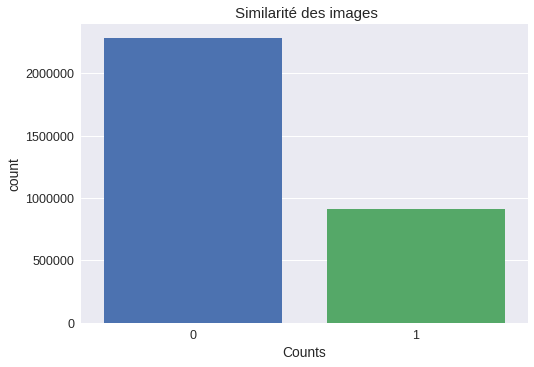

In [9]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

sns.set(font_scale=1.25)

p = sns.countplot(data=df[['y']],
                  x = 'y',saturation=2)
leg = p.get_legend()
p.set_title(" Similarité des images")
p.axes.xaxis.label.set_text("Counts")
#plt.text(900,2, "Bar Plot", fontsize = 95, color='Black', fontstyle='italic')

Effectivement , on observe que moins que 30 % des observations qui correspondent à des images similaires . Générallement , cela ne pose pas de problème lorsque le nombre d'observation est considérable , comme dans notre cas , mais on pourra faire de resampling ou de la pondération des observations pour équilibrer les classes . Ces approches ont été testé  ( avec le package SMOTE) mais cela n'a pas amélioré notre analyse . 
Essayons maintenant de voir les features des images et les comparer deux à deux : 

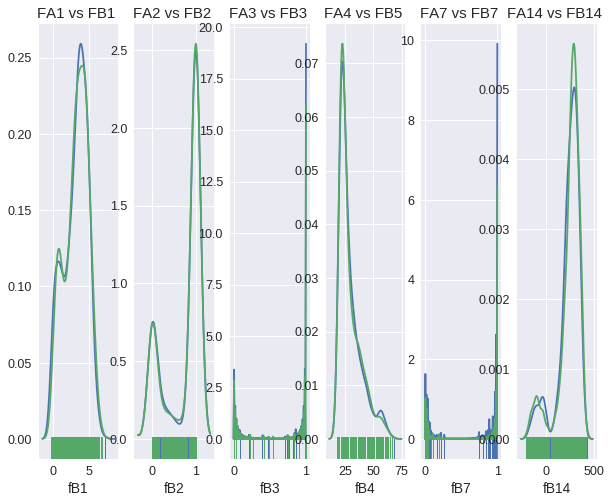

In [22]:
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(10,8))

sns.distplot(df.fA1[1:1000], hist=False, rug=True,ax=ax1)
sns.distplot(df.fB1[1:1000], hist=False, rug=True,ax=ax1)

sns.distplot(df.fA2[1:1000], hist=False, rug=True,ax=ax2)
sns.distplot(df.fB2[1:1000], hist=False, rug=True,ax=ax2)

sns.distplot(df.fA3[1:1000], hist=False, rug=True,ax=ax3)
sns.distplot(df.fB3[1:1000], hist=False, rug=True,ax=ax3)

sns.distplot(df.fA4[1:1000], hist=False, rug=True,ax=ax4)
sns.distplot(df.fB4[1:1000], hist=False, rug=True,ax=ax4)

sns.distplot(df.fA7[1:1000], hist=False, rug=True,ax=ax5)
sns.distplot(df.fB7[1:1000], hist=False, rug=True,ax=ax5)

sns.distplot(df.fA14[1:1000], hist=False, rug=True,ax=ax6)
sns.distplot(df.fB14[1:1000], hist=False, rug=True,ax=ax6)


ax1.set_title("FA1 vs FB1 ")  # remove y label, but keep ticks
ax2.set_title("FA2 vs FB2 ")  # remove y label, but keep ticks
ax3.set_title("FA3 vs FB3 ")  # remove y label, but keep ticks
ax4.set_title("FA4 vs FB5 ")  # remove y label, but keep ticks
ax5.set_title("FA7 vs FB7 ")  # remove y label, but keep ticks
ax6.set_title("FA14 vs FB14 ")  # remove y label, but keep ticks


plt.show()

Les graphes et les tables de statistiques affichés précedémment confirme qu'il n'y a pas d'incohérence entre les pairs des variables  FAi et FBi . Essayon maintenant d'observer la matrice de corrélation pour les FAi et les FBi  :


Text(0.5, 1.0, 'Corrélation entre les fBi ')

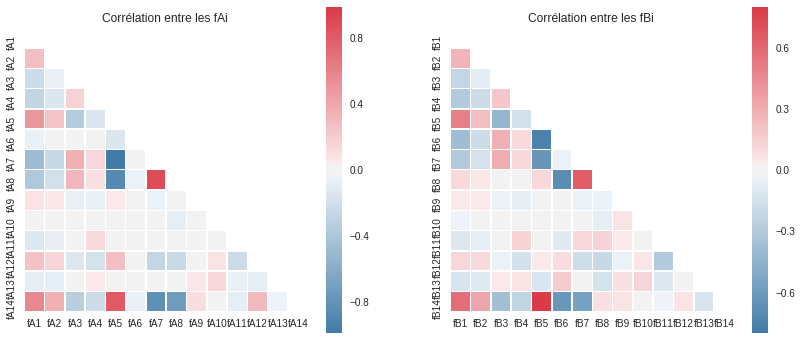

In [28]:

sns.set(style="white")

# #########################Features A ###################
d = df[listfeaturesA]

# Compute the correlation matrix FEATURES a
corr1 = d.corr()


d = df[listfeaturesB]

# Compute the correlation matrix features b
corr2 = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)

ax1.set_title("Corrélation entre les fAi ")
# #########################Features B ###################


mask2 = np.zeros_like(corr2, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask2, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title("Corrélation entre les fBi ")


D'après les deux graphes ci-dessus , on peut dire qu'il y a des features qui sont corrélées ( négativement ou positivement ) et il est peut etre envisageable  de les supprimer dans notre modélisation  :

*  fA14 est corrélée avec fa1 , fa5, fa7,fa8 , de meme pour fB 14
*  fA7 est fortement corrélé à fA8   , de meme pour fB7 et fB8
*  fA5 et fB5 sont négativement corrélée avec respectivement (fA7,fA8 ) et  (fB7,fB8 )


Pour traiter ces corrélations , on a testé plusieurs approche  : 
* Supprimer fA5 ,fa7 et fA14 
* Faire une analyse de composante principale ( ACP )
* Garder toutes variables et laisser l'algorithme de modélisation corriger cette corrélation

On discutera à la fin du notebook de l'approche retenue .


Passons maintenant aux variables de similarité S1 , S2 .. , S8 : 

Commençons par un pairplot des variables de scores  S1 ... S4 et le target Y

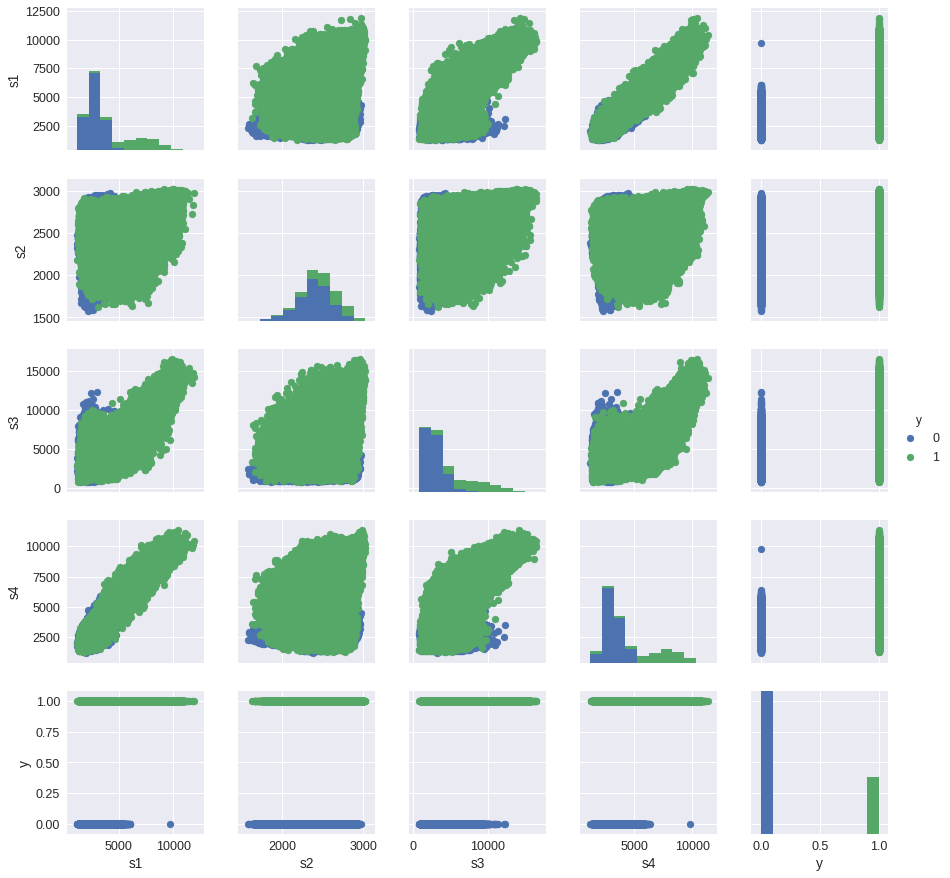

In [28]:
g = sns.PairGrid(df[['s1','s2','s3','s4','y']][1:300000],hue="y")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

D'après les pairplots , on remarque qu'il y a des valeurs extrèmes pour les scores S1 et S4 . De plus , on ne voit pas directement un critère de séparation entre les Si et Y . Il faudra peut-etre appliquer une transformation non linéare  aux features Si , on testera cela dans la modélisation.

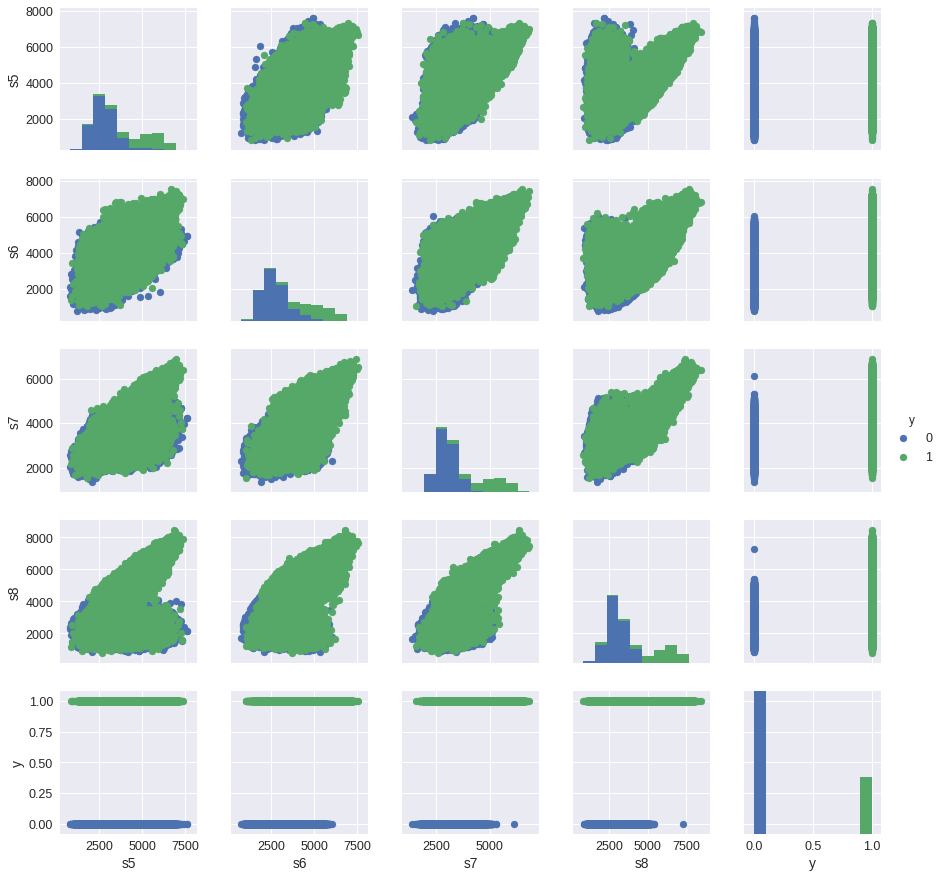

In [29]:
g = sns.PairGrid(df[['s5','s6','s7','s8','y']][1:300000],hue="y")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

Meme comportement observé pour les variables s7 et s8 , on a des outliers qu'il faut  traiter  .  Essayons de zoomer un peu plus sur quelques variables : 

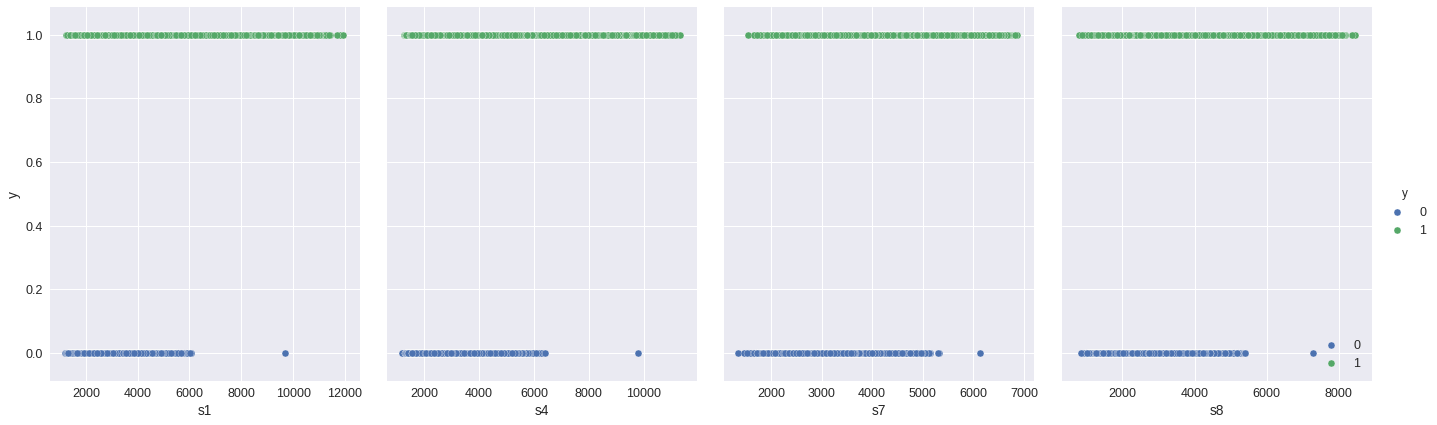

In [59]:
%matplotlib inline
plt.rcParams['figure.figsize']=10,10 
# Use the 'hue' argument to provide a factor variable
#sns.lmplot( x="s1", y="y", data=df[['s1','y']][1:700000], fit_reg=False, hue='y', legend=False)
g=sns.pairplot(df[['s1','s4','s7','s8','y']][1:300000], x_vars=["s1", "s4",'s7','s8'], y_vars=["y"],
             hue="y", aspect=2);
g.fig.set_size_inches(20,8)

# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.show()

Ici , on constate que : 
* Il y a des valeurs extrèmes pour pour s1 > 8000 et y=0
* des valeurs extrèmes  pour s4 > 8000 et y=0 
* des valeurs extrèmes pour s7 >6000 et y=0
* des valeurs extrèmes pour s8 > 6000 et y=0 

Pour traiter ces observations  , on a essayé deux approches : 
* soit les supprimer 
* soit les corriger en mettant y= 1

Notre souci était que ces observations existe dans l'échantillon de test , de ce fait  , on a fini par laisser ces valeurs ..
Regardons maintenant la corrélation entre les scores Si :

Text(0.5, 1.0, 'Corrélation entre les Si ')

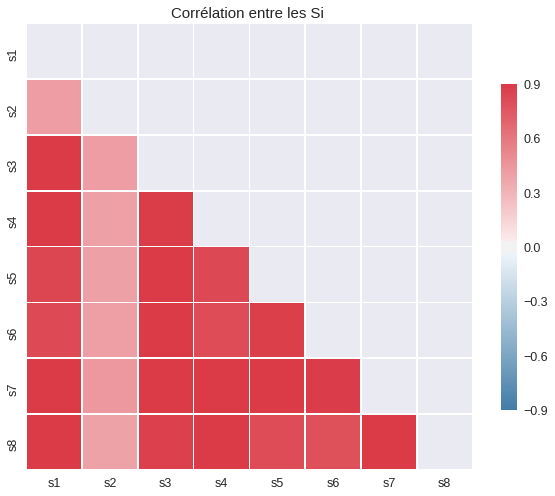

In [70]:
d = df[listscores]

# Compute the correlation matrix
corr1 = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})

plt.title("Corrélation entre les Si ")

Sauf la variable S2 , les autres  variables de scores sont  positivement corrélées entre eux , ce qui est normal , vu que toutes ces variables renseignent sur la similarité des paire d'images . On va essayer de selectionner uniquement quelques scores pendant la phase de modélisation et évaluer l'impact.
Observons maintenant la distribution des scores : 

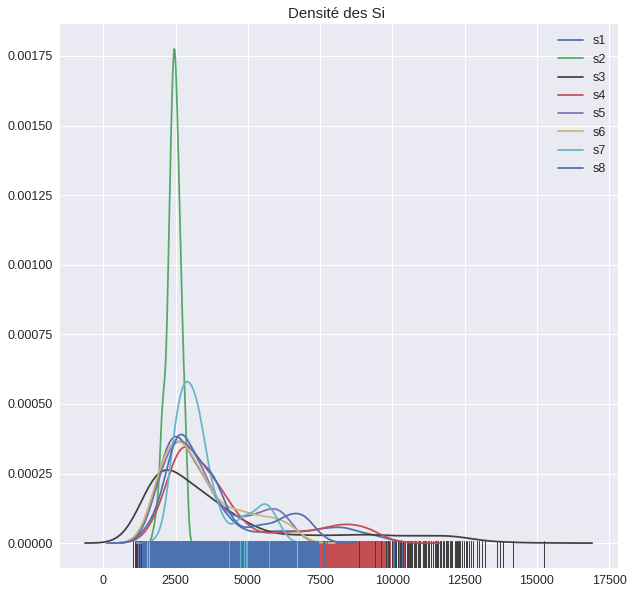

In [82]:

sns.distplot(df[['s1']][1:1000], hist=False, rug=True,label='s1')
sns.distplot(df[['s2']][1:1000], hist=False, rug=True,label='s2',)
sns.distplot(df[['s3']][1:1000], hist=False, rug=True,label='s3', color="0.25")
sns.distplot(df[['s4']][1:1000], hist=False, rug=True,label='s4')
sns.distplot(df[['s5']][1:1000], hist=False, rug=True,label='s5')
sns.distplot(df[['s6']][1:1000], hist=False, rug=True,label='s6')
sns.distplot(df[['s7']][1:1000], hist=False, rug=True,label='s7')
sns.distplot(df[['s8']][1:1000], hist=False, rug=True,label='s8')
plt.title("Densité des Si ")
plt.legend()
sns.plt.show()


D'après le graphe des distributions des scores , on  peut constater qu'il y a des variables qui ont ont la meme densité , comme  s4 , s7 et s8. On a a essayé de supprimer ou faire selectionner plusieurs combinaisons de ces variables dans la modélisation. Malheureusement , cela n'a pas infecté le résultat final .




### Données répliquées : 
On a constaté qu'au niveau de jeux de données , il y a des observations qui se répentent au niveau de jeux de train et aussi le test . On a constaté également , qu'il suffit d'inverser l'ordre des fAi et fBi sur une partie des données pour avoir des observations dans le test qui existent dans le train .

Essayons de savoir combien il y des données répliquées dans le train.


In [0]:
df1=df[df.duplicated()] ##### subset des données répliquées

In [87]:
print(" Il y a %s observations redondantes" %df1.shape[1]) ### il y a plus que 16 0000 sur le jeux entier

 Il y a 37 observations redondantes


On a essayé au début de supprimer  les observations rédondantes mais cela a affecté enormément la modélisation dans la mésure où on a obtenu un classifieur avec une erreur de classification de 50% , ce qui est très étrange , vu qu'il ne s'agit que d'une minorité d'observations .  Cela nous a améné à penser que ces observations expliquent bien la variance des données , on a essayé donc de les répliquer mais cela n'a pas marché .



# 2- Features engineering 


Rappelant la structure des données d'entrée :

In [88]:
df.head()

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10  fA11  fA12  fA13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00 -0.02  0.01 -0.01   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01 -0.07  0.09 -0.06   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00 -0.13  0.09 -0.05   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01 -0.06  0.21  0.03   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01 -0.13  0.08 -0.02   

     fA14   fB1   fB2  fB3  fB4  fB5  fB6  fB7   fB8   fB9  fB10  fB11  fB12  \
0  201.59  4.62  1.00  1.0   41  1.0  0.0  0.0  0.09  0.24  0.01 -0.09 -0.03   
1  179.02  0.85  0.00  0.0   51  1.0  0.0  0.0 -0.04 -0.10  0.02 -0.07  0.14   
2  374.03  4.34  0.99  0.0   26  1.0  0.0  0.0 -0.04  0.00  0.01 -0.15  0.26   
3  320.16  4.54  1.00  0.0   24  1.0  0.0  0.0 -0.08  0.04  0.01 -0.02  0.10   
4  162.15  4.25  0.00  0.0   22  1.0  0.0  0.0 -0.04  0.01  0.00 -0.05  0.02   

   fB13    fB14      s1      s2      s3      s4   

Notre problématique n'est pas une simple modélisation supervisée  qu'on pourra la résoudre avec une approche "Learn a classifier directly”. En fait , il y a des propriétées dans les données qu'il faut les incorporer dans le modèle : 
On est entrain de traiter une problématique de " pairwise similarity " , c'est à dire , on a un couple de features et on essaie de contruire une fonction  f : 
\begin{aligned} f({{x}}^{\alpha }, {{x}}^{\beta }) = \left\{ \begin{array}{rl} 1 &{} (\mathrm {si} \, {{x}}^{\alpha } \mathrm {et}\, {{x}}^{\beta } \mathrm {sont}\, {similaires})\\ 0 &{} (\mathrm {sinon}). \end{array} \right. \end{aligned}

Cette fonction doit vérifier la relation suivante : 
\begin{aligned}f({{x}}^{\alpha }, {{x}}^{\beta }) = f({{x}}^{\beta }, {{x}}^{\alpha })\end{aligned}


Pour tenir compte de cette similarité , on a ajouté des distance entre les features des pairs des images : 


1.   La norme eucliedienne
1.   La distance Manhattan
3.   Chi-squared kernel:

\begin{aligned} k(x, y) = \exp \left (-\gamma \sum_i \frac{(x[i] - y[i]) ^ 2}{x[i] + y[i]} \right )\end{aligned}







Voici un lien décrivant les différentes distance utilisée dans des problématiques de **pairwise classification**
https://scikit-learn.org/stable/modules/metrics.html


Il faudra peut-etre prendre les jeux de données intial , inverser les features A & B et concatener horizontalement ce nouveau jeux de donnée au dataset intial . Comme ça , le modèle apprendre la symétrie entre les features

###  2.1 Standardisation des données 

Comme on veut calculer des distances entres les pairs des features , on va normaliser les données des features pourqu'elle aient des valeurs positives , pour cela , on utilisera le **MinMaxScaler** . 
Pour les variables de scores { s1,s2, ....s8} ,  on a tester une standardisation avec **StandardScaler** et une autre avec **MinMaxScaler** et on n'a pas constaté une différence durant la phase d'apprentissage , de ce fait , on a gardé le meme scaler pour les features des images et les scores 

In [14]:



listfeatures=['fA'+str(x) for x in range(1,15)]+['fB'+str(x) for x in range(1,15)]
listfeaturesA=['fA'+str(x) for x in range(1,15)]
listfeaturesB=['fB'+str(x) for x in range(1,15)]


scaler = MinMaxScaler() #################### initialisation du scaler
xtrain_scaled = scaler.fit_transform(df[listfeatures+listscores]) ###### fit_transform du scaler
xtrain_scaled=pd.DataFrame(xtrain_scaled) ##### xtrain en dataframe
xtrain_scaled.columns=listfeatures+listscores ### reprendre les noms des colonnes

########################"" standardisation de l'échantillon du test "
xtest_scaled = scaler.transform(xtest[listfeatures+listscores])
xtest_scaled=pd.DataFrame(xtest_scaled)


print (" Scaling ............")
xtrain_scaled.head(2)

 Scaling ............


        fA1   fA2  fA3       fA4  fA5  fA6  fA7       fA8       fA9      fA10  \
0  0.502980  1.00  1.0  0.410714  1.0  0.0  0.0  0.471287  0.807388  0.535714   
1  0.228844  0.01  0.0  0.785714  1.0  0.0  0.0  0.564356  0.804749  0.517857   

       fA11      fA12      fA13      fA14       fB1  fB2  fB3       fB4  fB5  \
0  0.671642  0.456311  0.545455  0.645879  0.637280  1.0  1.0  0.418182  1.0   
1  0.634328  0.533981  0.488636  0.617317  0.162469  0.0  0.0  0.600000  1.0   

   fB6  fB7       fB8       fB9      fB10      fB11      fB12      fB13  \
0  0.0  0.0  0.552268  0.851852  0.563636  0.534884  0.417476  0.534884   
1  0.0  0.0  0.526627  0.754986  0.581818  0.558140  0.582524  0.500000   

       fB14        s1        s2        s3        s4        s5        s6  \
0  0.734729  0.115533  0.397376  0.065150  0.103707  0.174449  0.108278   
1  0.589641  0.255108  0.740899  0.122348  0.290287  0.380826  0.219239   

         s7        s8  
0  0.176500  0.158570  
1  0.354663  0.

In [0]:

############################ reconstruire df ( training )  et dtest  ###############################
df=xtrain_scaled
df['y']=ytrain
df=pd.DataFrame(df)


dftest=xtest_scaled
dftest.columns=listfeatures+listscores

In [16]:
df.describe()

                fA1           fA2           fA3           fA4           fA5  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   4.259423e-01  7.200140e-01  8.895844e-02  2.032548e-01  9.112188e-01   
std    1.929032e-01  4.224322e-01  2.824698e-01  1.748763e-01  2.757797e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.860548e-01  2.500000e-01  0.000000e+00  7.142857e-02  1.000000e+00   
50%    4.576877e-01  1.000000e+00  0.000000e+00  1.428571e-01  1.000000e+00   
75%    5.756853e-01  1.000000e+00  0.000000e+00  2.857143e-01  1.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                fA6           fA7           fA8           fA9          fA10  \
count  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06  3.196465e+06   
mean   4.165448e-03  8.456615e-02  5.311618e-01  8.073091e-01  5.352083e-01   
std    4.433567e-02  2.729676e-01  8.235861e-02  3.

### 2.2 Première modélisation avec RF &  importances des features 

Essayons une premières modélisation avec le modèle Random Forest

In [0]:
################################# Fonction permettant d'afficher l'importance des features ##################

def importances(estimator, col_array, title): 
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    print ("%s Top 8 Important Features\n" %title)
    for f in range(8):
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]])) 
    print ("\nMean Feature Importance %.6f" %np.mean(importances))
    indices=indices[:8]
    plt.figure(figsize=(10,10))
    plt.title(title+" Top Feature importances")
    plt.bar(range(8), importances[indices], color="gr", align="center")
    plt.xticks(range(8), col_array.columns[indices], fontsize=14, rotation=90)
    plt.xlim([-1, 8])
    plt.show()

In [98]:

random_seed = 42


################################ splitter les données #######################################
X_train_metric, X_test_metric, y_train_metric, y_test_metric = train_test_split(df.drop('y',axis=1), df['y'],
                                                    train_size=0.85, random_state=random_seed)

print(X_train_metric.shape)
print(X_test_metric.shape)


(2716995, 36)
(479470, 36)


In [99]:
############################ fitter le classifieur #####################
rf=RandomForestClassifier( bootstrap=True, oob_score=True,n_estimators=10,criterion='entropy')
rf.fit(X_train_metric,y_train_metric)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

 Première vue des importances des variables---  Top 8 Important Features

1. s4 (0.185970)
2. s5 (0.138508)
3. s8 (0.125030)
4. s3 (0.108856)
5. s1 (0.097165)
6. s7 (0.070471)
7. s2 (0.041873)
8. s6 (0.030539)

Mean Feature Importance 0.027778


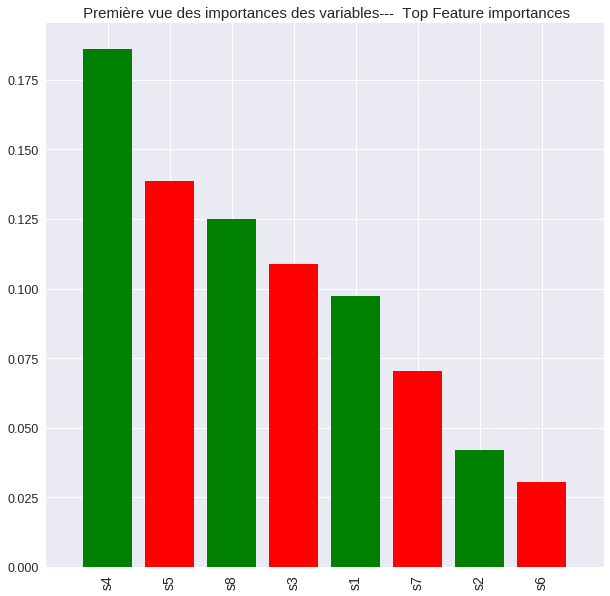

In [104]:
importances(rf,X_train_metric," Première vue des importances des variables--- ")

Assez intéressant , là on voit que si on met directement les fAi et les fBi dans la modélisation , les modèles d'arbres n'arrivent pas à comprendre qu'il s'agissent des pairs d'images . Il y a des modèles plus compliqées comme un réseaux de neurones multicouches ou du SIAMESE Networks qui seront vraismembablement capable de décortiquer ces attributs . 
Néanmoins , on va continuer avec les modèles d'arbres , mais en ajoutant des features de similarité calculé à partir des fAi et fBi  . 

Avant de passer au features engineering , essayant d'évaluer la précision du modèle intial pour avoir un benchmark

In [106]:
##################################### Prédiciton des proba et des labels #################""

y_prob = rf.predict_proba(X_test_metric)[:,1] # Calculer les probabilités  
y_pred = np.where(y_prob > 0.5, 1, 0)### calculer les labes


####################################" Matrice de confusion #############################"
print("La matrice de confusion du première modèle est : ")
confusion_matrix=metrics.confusion_matrix(y_test_metric,y_pred)
confusion_matrix

array([[341056,   1017],
       [  6553, 130844]])

In [109]:
################################# AUC score #############################

auc_roc=metrics.roc_auc_score(y_test_metric,y_pred)
print ("Le score AUC lu premier modèle est %.2f%%" %(100*auc_roc))

Le score AUC lu premier modèle est 97.47%


Text(0.5, 0, 'False Positive Rate')

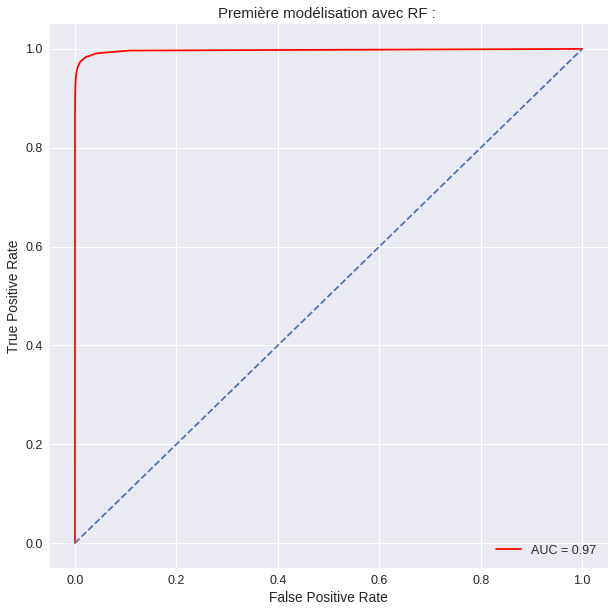

In [111]:

##################################### Plot the roc curve #############################
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_metric, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
plt.figure(figsize=(10,10))
plt.title('Première modélisation avec RF : ')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % auc_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Rien qu'en faisant le scaling de variables , on obtient une précision qui voisine les 98% !!  
Essayant tout de meme d'améliorer le modèle et travailler un peu plus sur les données 

### 2.3 Construction des variables de distance : 

Pour la constructions des variables de distances entre les features des images , on va éliminer les variables fA5 , fA7 et fA14  , fB5,fB7 et fB14 car elles sont très corrélées comme on l'a vu dans le heatmap au début de l'anlayse exploratoire : 

In [18]:
##########################" vecteur des nom des features  ########################
listfeatures=['fA'+str(x) for x in range(1,15)]+['fB'+str(x) for x in range(1,15)]
listfeaturesA=['fA'+str(x) for x in range(1,15)]
listfeaturesB=['fB'+str(x) for x in range(1,15)]
listscores=['s'+str(x) for x in range(1,9)]


############################################################ Quelques fonctions utiles de distance ###############################################################

def manhattan_distance(p_vec, q_vec):
        """
        This method implements the manhattan distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the manhattan distance between vector one and two
        """
        return np.sum(np.fabs(p_vec - q_vec))

def square_euclidean_distance( p_vec, q_vec):
        """
        This method implements the squared euclidean distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the squared euclidean distance between vector one and two
        """
        diff = p_vec - q_vec
        return np.sum(diff**2)
    
def half_square_euclidean_distance(p_vec, q_vec):
        """
        This method implements the half squared euclidean distance metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the half squared euclidean distance between vector one and two
        """
        return 0.5 * square_euclidean_distance(p_vec, q_vec)

def cosine_similarity( p_vec, q_vec):
        """
        This method implements the cosine similarity metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the cosine similarity between vector one and two
        """
        pq = p_vec* q_vec
        p_norm = np.sqrt(p_vec)
        q_norm =  np.sqrt(q_vec)
        return pq / (p_norm * q_norm + 1)
      
      
def tanimoto_coefficient( p_vec, q_vec):
        """
        This method implements the cosine tanimoto coefficient metric
        :param p_vec: vector one
        :param q_vec: vector two
        :return: the tanimoto coefficient between vector one and two
        """
        pq = p_vec* q_vec
        p_square = p_vec**2
        q_square =q_vec**2
        return pq / (p_square + q_square - pq+1)
      
                     

    
### on supprime les features 5,7 et 14

listcomp2=[1,2,3,4,6,8,9,10,11,12,13] 

for i in listcomp2 : 
    print("calcul des distances pour la composante %s"%i)
    
    ###### calcul pour le train
    df["fABm2"+str(i)]=10*(df["fA"+str(i)]-df["fB"+str(i)])**2 /(df["fA"+str(i)]+df["fB"+str(i)]+0.05) ## chi squared kernel
    df["fABe2"+str(i)]=10*abs(0.5*(df["fA"+str(i)]-df["fB"+str(i)])**2) ### équivalement à la distance euclidienne
    df["fABd2"+str(i)]=(df["fA"+str(i)]*df["fB"+str(i)])/(df["fA"+str(i)]**2 +df["fB"+str(i)]**2 - df["fA"+str(i)]*df["fB"+str(i)] +0.05) ### une nouvvemme mesure de distance 
    
    ##### clacul pourle test
    dftest["fABm2"+str(i)]=10*(dftest["fA"+str(i)]-dftest["fB"+str(i)])**2 /(dftest["fA"+str(i)]+dftest["fB"+str(i)]+0.05) ## chi squared kernel
    dftest["fABe2"+str(i)]=10*abs(0.5*(dftest["fA"+str(i)]-dftest["fB"+str(i)])**2)
    dftest["fABd2"+str(i)]=1*(dftest["fA"+str(i)]*dftest["fB"+str(i)])/(dftest["fA"+str(i)]**2 +dftest["fB"+str(i)]**2 - dftest["fA"+str(i)]*dftest["fB"+str(i)] +0.05)
                                                          

calcul des distances pour la composante 1
calcul des distances pour la composante 2
calcul des distances pour la composante 3
calcul des distances pour la composante 4
calcul des distances pour la composante 6
calcul des distances pour la composante 8
calcul des distances pour la composante 9
calcul des distances pour la composante 10
calcul des distances pour la composante 11
calcul des distances pour la composante 12
calcul des distances pour la composante 13


Calculons maintenant quelques distances aggrégées sur les features . 
**(** Les variables ci-dessous ont été choisies après avoir essayer plusieurs combinaisons et métrics et regarder leurs apports dans le modèle **)**

In [19]:
############################ dot product #############################
#### train
a=df[listfeaturesA] * df[listfeaturesB].values
df["s44"]=a.sum(axis=1)/10
#### test
a=dftest[listfeaturesA] * dftest[listfeaturesB].values
dftest["s44"]=a.sum(axis=1)/10



#### vider les variables de la RAM
del a;  gc.collect()
del scaler;  gc.collect()
del xtrain;  gc.collect()
del xtrain_scaled;  gc.collect()
del xtest_scaled;  gc.collect()

0

In [0]:

########################### calcul de chi-squerd kernel avec gamma =0.5 ####################
gamma=0.5
df['s11'] = np.exp(-gamma*(df[["fABm2"+str(i) for i in listcomp2 ]].sum(axis=1)))
dftest['s11'] = np.exp(-gamma*(dftest[["fABm2"+str(i) for i in listcomp2 ]].sum(axis=1)))

In [0]:
########################### log de la distance L2  ####################


df['s22'] = np.log(abs(df[["fABe2"+str(i) for i in listcomp2 ]].sum(axis=1)))/10
dftest['s22'] = np.log(abs(dftest[["fABe2"+str(i) for i in listcomp2 ]].sum(axis=1)))/10

In [22]:

########## recupérer les noms des colonnes finales ###########
listcol=df.columns
del xtest;  gc.collect() ## vider la ram de xtest

43

In [23]:
print("La nouvelle base de training : ")
df.head()

La nouvelle base de training : 


              fA1  fA2  fA3       fA4   fA5  fA6   fA7       fA8       fA9  \
285695   0.475566  1.0  0.0  0.053571  1.00  0.0  0.00  0.584158  0.762533   
1475336  0.250298  1.0  0.0  0.035714  1.00  0.0  0.00  0.510891  0.778364   
134844   0.597139  0.0  0.0  0.196429  1.00  0.0  0.00  0.526733  0.786280   
2981914  0.600715  1.0  0.0  0.160714  1.00  0.0  0.00  0.504950  0.804749   
458920   0.519666  1.0  0.0  0.160714  0.87  0.0  0.13  0.489109  0.817942   

             fA10      fA11      fA12      fA13      fA14       fB1   fB2  \
285695   0.410714  0.619403  0.728155  0.636364  0.619607  0.735516  1.00   
1475336  0.553571  0.559701  0.699029  0.431818  0.887650  0.521411  1.00   
134844   0.535714  0.708955  0.495146  0.386364  0.633806  0.521411  0.01   
2981914  0.535714  0.664179  0.436893  0.556818  0.743208  0.670025  1.00   
458920   0.589286  0.626866  0.466019  0.590909  0.562192  0.425693  1.00   

         fB3       fB4  fB5  fB6    ...       fABe28    fABd28    fA

Après avoir diagnostiquer les données  et faire quelques esssais de modélisation , on a conclu qu'on a pas besoin de rescaler les données après les features engineering car les nouveaux variables calculées sont déjà comparables .

Pour la partie **Cleaning** des données , ci dessous les tentatives essayées : ,
* On a commencé par supprimer les observations redondantes mais cela a détérioré la modélisation 
* On a essayé de faire de resampling des observations de classe 1 pour équilibrer les items , cela n'a pas affecté le résultat et a engendré un temps supplémentaire de calcul et a saturé la RAM . On a essayé la fonction SMOTE mais étant donnée la volumétrie des données et le nombre des features , cela n'a pas pu étre implémenté sur la base entière . 
* Pour les **Outliers**  , on a commencé par les supprimer , mais vu qu'il en existe sur l'échantillon test , on les a laissés . On a essayé de les corriger pour les mettre dans la bonne classe mais malheureusement cela n'a pas abouti à l'amélioration de l'apprentissage . On a essayé une technique de clustering qui s'appelle  **DBScan** pour identifier et isoler les variables mais cela n'était pas possible sur sur le jeux de données entier ( ça prend du temps .... )
*On a vu qu'il y a des variables de similarité comme S1 et S8 qui ont des distributions très proches , on a essayé  de les supprimer ou en faire des **combinaisons polynomiales** mais , pour des contraintes de mémoires , on a abondonnée cette piste car ces transformations sont très gourmande en RAM ...
* On a essayé l'analyse de composante principale ( **ACP** ) pour transformer la dimension d'entrée du modèle mais cela n'a pas amélioré les scores .



Passant maintenant à l'étape de modélisation : 

# 3- Modélisation 



Après avoir construit les features , on a essayé plusieurs modèles pour prédire la similarité entre les images et on s'est aperçu que le capacités techniques des machines sont cruciales pour avoir une bonne précision .Malheureusement , c' était une contrainte que je n'ai pas réussi à la contourner , de ce fait ,  je n'ai pas pu étendre la liste des valeurs des paramètres d'apprentissage durant la phase de tuning . 
Poir le challenge , ci-dessous un résumé de la méthodologie utilisée : 
* J'ai commencé par tirer aléatoirmeent et sans remise sur l'échantillon de test 50% des observations . Cette échantillon servera à tuner les paramètre du  modèle . 
* J'ai testé plusieur modèles de classification avec des paramètres diversifiés , à savoir , **RandomForest** de SKlearn et RandomForest de **Tensorflow** ,  **SVM** avec un noyeau linéaire , **réseau de neurones** sous tensorflow en faisant le tuning sur { le nombre de couches , le nombre de neurones , les fonctions d'activation , le learaning rate } , **KNN**  sur les scores de similarité {s1,s2;s3,s4...s8} , **XGBOOST** de sklearn , **EXTRATREES** , et enfin **lightGBM**
* J'ai tuné tous les modèles avec 5-Fold  **Crossvalidation** 
* J'ai essayé de faire du **Stacking**  en combinant les prédictions  de tous les classifieurs avec les variables de similarités initiales , cela a bien marché sur 50% des données  ( le meilleur modèle obtenu ) mais je n'ai pas réussi à le faire tourner sur ma machine en local sur le jeux de données entier ...
* Je suis revenu vers les réseaux de neurones et le modèle lightGBM , les résultats obtenus avec les deux modèles étaient **moins bons** que le stacking mais on n'avait pas de choix vu les contraintes techniques. 
* Enfin , j'ai gardé le modèle **LightGBM** et j'ai essayé de tuner ses paramètres en utilisant **GridSearchCV** et aussi une technique bayésienne d'optimization des paramètres qui a mieux marché . L' avantage de l'approche bayésienne est qu'on cherche d'une façon séquentielle les paramètre en incorportant à chaque itération les connaissance à priori de l'itération précedante ( comme **la théorie des bandits** ). 






## 3.1 Explication rapide du modèle choisi  : 

Mon expérience sur Kaggle m'a fait choisir de passer la majorité de mon temps sur un algorithme nommé XGBoost. Historiquement, c'est un algorithme utilisé dans la quasi-totalité des solutions gagnantes sur les compétitions de ces deux dernières années (parfois en combinaison avec d'autres modèles). XGBoost est l'abbréviation de “Extreme Gradient Boosting” et repose sur le modèle des Boosted Trees, un ensemble d'arbres de décisions dont l'apprentissage se fait par Boosting, c'est-à-dire de manière séquentielle, chaque nouvel arbre se basant sur les résultats déjà recueillis sur les précédents. Pour une explication détaillée sur cet algorithme 
https://xgboost.readthedocs.io/en/latest/model.html .  J'ai commencé par utilisé XGBOOST dans ce challenge mais je n'ai pas réussi à faire le tuning et la cross-val sur un nombre important d'estimators à cause de la RAM de ma machine . 


De ce fait , je suis passé à une version "light" de XGBM qui est LightGBM . Il s'agit d'une version distribué de gradient boosting , basée sur les arbres de décisions , utilisée pour les problématiques de ranking et aussi de classification et de regression. L'algorithme utilise une approche "leaf-wise" pour trouver le best fit , contrairmeent à XGB qui utilise une approche "level or depth  wise" . 
![Texte alternatif…](https://raw.githubusercontent.com/kasamoh/Data-analysis/master/Challenge_ML/leafwise.JPG)


Il y a plusieurs paramètres à tuner , mais on se focalisera surtout sur le learning rate et le leaf_size . 
Comme mentionné avant , on a  choisi  l'optimisation Bayesienne pour tuner les paramètres . C'est une méthode qui cherche à trouver la valeur maximale d'une fonction inconnue, en aussi peu d'itérations que possible. Je ne rentrerai pas dans les explications mathématiques du concept, j'en serais d'ailleurs bien incapable, mais il vous reste toujours Google! Niveau implémentation, par contraste avec un GridSearch, ici on ne fournit pas un ensemble de valeurs possibles pour chaque paramètre, mais une borne minimale et une maximale, l'algorithme se chargeant d'explorer cet espace de manière intelligente. Pour un exemple d'implémentation en Python : https://github.com/fmfn/BayesianOptimization

### 3.1 Séparation des données en train , validation et test 

Commençons par séparer le jeux de données en train , validation et test

In [0]:
random_seed = 42
################################# split ###############################


X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'],axis=1), df.y,train_size=0.95, random_state=random_seed) ######## echantillon test et train


X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, train_size=0.95, random_state=random_seed) #### splitter le train en train et validation

In [25]:
print("Les shape X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1153923, 72)
(60733, 72)
(63930, 72)


### 3.2  Tuning des paramètres et choix du modèle en utilisant BayesianOptimization

Après avoir splitter les donner , il fallait les transformer en un format spécifique du package lightGBM :

In [0]:
####################################### transformation en format lgbm ################
#X_train.drop(range(0,28),axis=1)
train_data=lgb.Dataset(X_train,label=y_train)
valid_data=lgb.Dataset(X_val,label=y_val)

Maintenant , on fera le tuning des paramètres en utilisant  **BayesianOptimization**

In [0]:


###################################### Bayeisan optimization #################################

#C'est juste pour une démontration , il faut faire tourner le code en augmentat "initial rounds", "optimization rounds" et "n_estimators"

X = df.drop('y', axis=1)
y = df.y
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=1000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y,  free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        params = {'objective':'binary','n_estimators': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        
                
        
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (30,50),
                                            'feature_fraction': (0.5, 0.9),
                                            'bagging_fraction': (0.8, 0.98),
                                            'max_depth': (10,20),
                                            'min_split_gain': (0.01, 0.1),
                                            'min_child_weight': (2, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    #if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=100, n_folds=3, random_seed=6, n_estimators=500, learning_rate=0.05)

![Texte alternatif…](https://raw.githubusercontent.com/kasamoh/Data-analysis/master/Challenge_ML/bayesian.JPG)

On a mis ci-dessus une capture du process d'optimization car cela prend énormément du temps . 
Ci-dessous les paramètres optimaux pour le modèle . On a pu améliorer les résultat si on pousse "n_estimators"  à  10000 ou 15000

In [0]:
#Select Hyper-Parameters
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.75,
          'is_unbalance':True ,
          'feature_fraction':0.6,
          'drop_rate':0.3,
          'num_leaves' : 60,
          'max_depth' : -1,
          'n_estimators' : 500,
          'min_child_samples': 399, 
          'min_child_weight': 0.5,
          'subsample': 0.8,
          'verbose' : -1,
          'num_threads' : 4,
          'objective': 'binary',
                              'learning_rate': 0.05,
            'min_split_gain':.2
}

Faisant maintenant le training avec les paramètres trouvé

In [31]:
################################# fitter le modèle #########################
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.994801
[20]	valid_0's auc: 0.995337
[30]	valid_0's auc: 0.995598
[40]	valid_0's auc: 0.996224
[50]	valid_0's auc: 0.996548
[60]	valid_0's auc: 0.996894
[70]	valid_0's auc: 0.997134
[80]	valid_0's auc: 0.997329
[90]	valid_0's auc: 0.997479
[100]	valid_0's auc: 0.997627
[110]	valid_0's auc: 0.997753
[120]	valid_0's auc: 0.997854
[130]	valid_0's auc: 0.997946
[140]	valid_0's auc: 0.998033
[150]	valid_0's auc: 0.998114
[160]	valid_0's auc: 0.998186
[170]	valid_0's auc: 0.998249
[180]	valid_0's auc: 0.998303
[190]	valid_0's auc: 0.998348
[200]	valid_0's auc: 0.998402
[210]	valid_0's auc: 0.998444
[220]	valid_0's auc: 0.998481
[230]	valid_0's auc: 0.998515
[240]	valid_0's auc: 0.998544
[250]	valid_0's auc: 0.998568
[260]	valid_0's auc: 0.998591
[270]	valid_0's auc: 0.998615
[280]	valid_0's auc: 0.998633
[290]	valid_0's auc: 0.998652
[300]	valid_0's auc: 0.998669
[310]	valid_0's auc: 0.99868
[320]	valid_0's a

###  3.3 Evaluation du modèle

Essayons maintenant d'évaluer le modèle en utilisant l'AUC de la courbe ROC

In [36]:

######################################### Prediction ############################
y_prob = lgbm.predict(X_test) # Calculer les probabilités  
y_pred = np.where(y_prob > 0.5, 1, 0)### calculer les labes

######################################### matrice de confusion ############################

print("La matrice de confusion du LightGBM est : ")
confusion_matrix=metrics.confusion_matrix(y_test,y_pred)
confusion_matrix

La matrice de confusion du LightGBM est : 


array([[45195,   413],
       [  400, 17922]])

In [35]:
######################################### score auc ############################

auc_roc=metrics.roc_auc_score(y_test,y_pred)
print ("Le score AUC LightGBM est %.2f%%" %(100*auc_roc))

Le score AUC LightGBM est 98.46%


Text(0.5, 0, 'False Positive Rate')

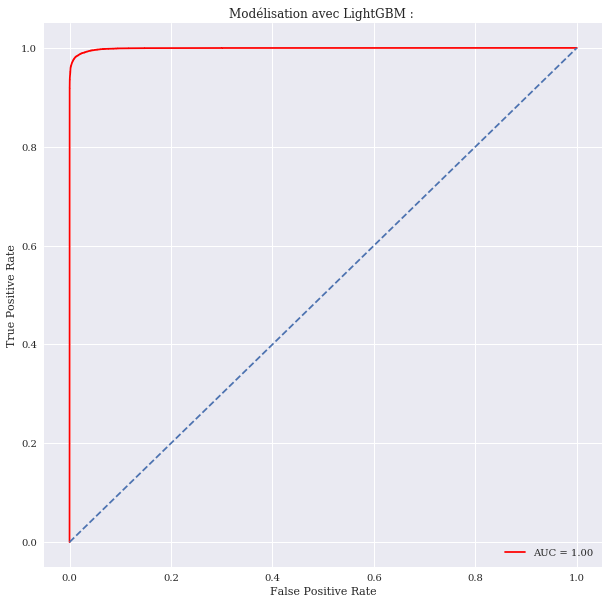

In [37]:

######################################### courbe roc ############################

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
plt.figure(figsize=(10,10))
plt.title('Modélisation avec LightGBM : ')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Très bien !  Si on se base sur l'AUC , le modèle LightGBM est meilleur que RandomForest  et Les reseaux de neurones , on a aussi essayé de le comparer avec KNN qui a donné un bon score , mais LightGBM avait le meilleur score sur les modèles testés sur tous le jeux de donnée . 
Le temps d'exécution était acceptable pour LightGBM ( de l'ordre d'une heure) , contrairement aux réseaux de neurones et XGBOOST  dont le temps de training dépasse les 3 heures . 

## 3.4 Submit des résultats
Lors de l'examination du jeux de données test , on s'est rendu compte de plusieurs points étranges sur les observations  :
* Il y avait des observations qui sont répétées 
* il y a des observations qui existe dans le train et le test 
* si on inverve les colonnes fAi et fBi dans l'échantillon de test  , on trouvera plusieurs observations qui se trouve dans le train 
* Les  outliers  sur S1 , S4 et S8 existent aussi sur le jeux de test , il faudra éventuellement calculer leurs prédictions à la main .
* Les points précedants pourraient améliorer le score mais cela est purement manuel .La modélisation n'a pas pu malheureusement bien capter cette symétrie de données . 
* On a choisi de ne pas faire le traitement manuel des prédictions et utiliser une approche purement automatisable .

Le meilleur score obtenu  était **0.9936 **  qui correspond au rang 30 de la compétition .





In [0]:
################# script pour submitter les résultat ##########################

#########" prediction sur le test ###################"
y_prob = lgbm.predict(dftest) # Calculer les probabilités  
y_pred = np.where(y_prob > 0.5, 1, 0)### calculer les labes

#################" export ###########################"
np.savetxt('y_challenge_submit.csv', ypred.values , fmt = '%1.0d', delimiter=',')

Ci-dessous un comparatif des résultats de quelques modèles submittés:

In [39]:
################################################### Récap des résultats ###################################################

print (" ################  Sur le jeux de submit : ")
print ( " * Random Forest a donnée un score auc = %.3f " %(0.9742))
print ( " * Xgboost avec 100 estimators a donnée un score auc = %.3f" %(0.9912))
print ( " * Le réseaux de neurones à 4 couches avec RELU comme activation sur le les couches cachées , 56 neurones sur chaque couches , learning rate = 0.1  a donnée un score auc = %.3f" %(0.9897))
print ( " * LightGBM avec 500 estimators , learning rate = 0.05  a donnée un score auc = %.3f" %(0.9936))


 ################  Sur le jeux de submit : 
 * Random Forest a donnée un score auc = 0.974 
 * Xgboost avec 100 estimators a donnée un score auc = 0.991
 * Le réseaux de neurones à 4 couches avec RELU comme activation sur le les couches cachées , 56 neurones sur chaque couches , learning rate = 0.1  a donnée un score auc = 0.990
 * LightGBM avec 500 estimators , learning rate = 0.05  a donnée un score auc = 0.994


## 4. Conclusion 
Le challenge était très fructueux dans la mésure où on a eu l'occasion de manipuler et implémenter plusieurs packages sur sickitlearn et tensorflow  et comprendre les incohérences sur les données . 
La majorité des modèles implémentés donne une précision qui dépasse les 99% sur le jeux de données entier , sans pre-processing des données . De ce fait , la marge d'amélioration n'était pas large et il se peut qu'il y a des approches qui auraient pu mieux marcher si le jeux de données était plus bruité . 
Le seul inconvenient que j'ai trouvé dans ce challenge était la volumétrie des données . Cela a biaisé un peu les scores dans la mesures où les machines les plus performantes auront plus de chances d'avoir un score plus elevé . J'ai essayé d'utiliser RandomForest avec scala pour voir la difference , malheureusement cela  a donné un score de 93% mais c'était plus rapide que les algorithmes de sickit . 
Enfin , je pense qu'il y a un souci sur une partie des données redondantes mais je n'ai pas pu l'identifier . 
Merci beacoup pour ce challenge !  

## Annexe de quelques modèles testés

Ci dessous quelques implémentation testé sur le challenge , je pourrai fournir tous les modèles si demandé

In [0]:

################################# Voting Classifier######################################


param_grid={'n_estimators': [50,100,250],
            'max_depth': [10,12,20],
            'criterion' :['gini','entropy']
           'max_features': [10,15,20],
#             'oob_score': ['True']
             'n_jobs': [4]
           }

n_jobs=2


rf=RandomForestClassifier( bootstrap=True, oob_score=True,n_estimators=10,criterion='gini',max_features=10)  ### randomforest

gb = GradientBoostingClassifier(n_estimators=10, learning_rate = 0.1,  random_state = 0,verbose=1,max_depth=5)### gradient boosting
adab = AdaBoostClassifier(RandomForestClassifier(max_depth=8),n_estimators=300,algorithm="SAMME.R") ### adaboots

############################## trainer les modele ensemble #############################
rf.fit(X_train_metric[listscores+['s11','s22','s33','s44']],y_train_metric)

In [0]:
############################################ Random Forest with tensorflow #########################


# Random Forest Classification on Tensorflow

cfg = keras.backend.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
keras.backend.set_session(keras.backend.tf.Session(config=cfg))
keras.backend.clear_session()

keras.backend.clear_session()

tf.reset_default_graph()

initialize = tf.global_variables_initializer()
sess = tf.Session()

sess.run(initialize)


# Import data

df=df.dropna(how='any')    #to drop if any value in the row has a nan



#Extract feature and target np arrays (inputs for placeholders)
input_y = df['y'].values
input_x =  df_feat_scaled.apply(lambda x: x.astype('float32')).values




# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_x, input_y, test_size = 0.1, random_state = 42)

#X_train, X_test, y_train, y_test = X_train_metric, X_test_metric, y_train_metric, y_test_metric 




# Parameters

num_steps = 5 # Total steps to train

num_classes = 2 

num_features = 11

num_trees = 50

max_nodes = 1000 



# Input and Target placeholders 

X = tf.placeholder(tf.float32, shape=[None, num_features])

Y = tf.placeholder(tf.int64, shape=[None])



# Random Forest Parameters

hparams = tensor_forest.ForestHParams(num_classes=num_classes, num_features=num_features, num_trees=num_trees, max_nodes=max_nodes).fill()



# Build the Random Forest

forest_graph = tensor_forest.RandomForestGraphs(hparams)



# Get training graph and loss

train_op = forest_graph.training_graph(X, Y)

loss_op = forest_graph.training_loss(X, Y)



# Measure the accuracy

infer_op, _, _ = forest_graph.inference_graph(X)

correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))

accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



# Initialize the variables (i.e. assign their default value) and forest resources

init_vars = tf.group(tf.global_variables_initializer(), resources.initialize_resources(resources.shared_resources()))

    

# Start TensorFlow session




# Run the initializer

sess.run(init_vars)



# Training

for i in range(1, num_steps + 1):

    _, l = sess.run([train_op, loss_op], feed_dict={X: X_train, Y: y_train})

    if i % 5 == 0 or i == 1:

        acc = sess.run(accuracy_op, feed_dict={X: X_train, Y: y_train})

        print('Step %i, Loss: %f, Acc: %f' % (i, l, acc))



# Test Model

print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: X_test, Y: y_test}))

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10  fA11  fA12  fA13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00 -0.02  0.01 -0.01   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01 -0.07  0.09 -0.06   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00 -0.13  0.09 -0.05   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01 -0.06  0.21  0.03   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01 -0.13  0.08 -0.02   
5  1.02  0.00  0.0   28  0.2  0.8  0.0 -0.73  0.00  0.03 -0.23  0.00  0.23   
6  1.28  1.00  0.0   21  1.0  0.0  0.0 -0.01 -0.01  0.00 -0.02  0.02 -0.02   
7  4.55  1.00  0.0   21  1.0  0.0  0.0  0.01 -0.13  0.00 -0.12  0.26 -0.12   
8  1.96  0.98  0.0   20  1.0  0.0  0.0  0.00  0.02  0.00 -0.09 -0.03  0.01   
9  3.50  0.01  0.0   25  1.0  0.0  0.0  0.00  0.03  0.00 -0.01  0.05 -0.02   

     fA14   fB1   fB2  fB3  fB4  fB5  fB6  fB7   fB8   fB9  fB10  fB11  fB12  \
0  201.59  4.62  1.00  1.0   41  1.0  0.0  0.0  0.09  0.24  0

In [0]:
##################################### ANN avec keras ##########################""

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
import tensorflow as tf
from keras.layers import GaussianNoise
from keras.layers import Activation

tf.keras.backend.clear_session()
keras.backend.clear_session()

classifier = Sequential()
classifier.add(Dense(output_dim = 45,init = 'uniform', activation = 'relu', input_dim = 82))
#classifier.add(GaussianNoise(0.2))
classifier.add(Dense(output_dim = 45, init = 'uniform', activation = 'relu'))
#classifier.add(GaussianNoise(0.1))
classifier.add(Dense(output_dim = 35, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 35,init = 'uniform', activation = 'relu'))

classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("start fitting...")
classifier.fit(df.drop('y',axis=1),df['y'], batch_size = 1000, nb_epoch = 5)

start fitting...
Epoch 1/5
 586000/3196465 [====>.........................] - ETA: 45s - loss: nan - acc: 0.0012

KeyboardInterrupt: ignored

In [0]:

y_pred = classifier.predict(X_test_metric)
y_pred = (y_pred > 0.52)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test_metric, y_pred)
print(cm)
print( accuracy_score(y_test_metric, y_pred))


[[226401   1387]
 [  3134  88725]]
0.9858562727008231


In [0]:
# Load test data
# Classify the provided test data

y_pred_f = classifier.predict(x_test_scaled)
y_pred_f = (y_pred_f > 0.53)


[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [ True]]
